# Inference of Gene Regulatory Network using Kinetic Ising Model


In [1]:
from datetime import date 
# Prints the last run date of the script for tracking purposes
print("Last run date:", date.today())

Last run date: 2024-08-13


In [2]:

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os  
from pathlib import Path

# Importing custom modules for specific functionalities
import lib.fun_plotting as fun_plotting
import lib.funcs_general as funcs_general
import lib.funcs_IsingPars as funcs_Ising
import lib.funcs_ko as funcs_ko
import lib.funcs_sanity as funcs_sanity
import lib.figs_funcs as figs_funcs

# Setting up matplotlib to use LaTeX for text rendering
matplotlib.rc('text', usetex=True)

# Setting up seaborn for aesthetics
sns.set(font='Avenir')
sns.set(style="white")

# Enabling autoreload extension for automatically reloading modules
%load_ext autoreload
%autoreload 2

# Loading Info and Data

## Information

In [3]:
# Defining paths for code and data directories
path      = os.getcwd() # "/GRN_Inference/GRN_Inference_CODE/" 
path_gen = os.path.dirname(path) # "/GRN_Inference/"
path_data = path_gen + "/DATA/"

In [4]:
# Loading the order of genes from a CSV file
genes_relevant = np.loadtxt(path_data + "general_info/genes_order.csv", dtype="str")

# Timepoints for the dataset
time = ["00h", "06h", "12h", "24h", "48h"]

# Classifying genes based on the Carbognin paper (2023)
naive = ["Klf4", "Klf2", "Esrrb", "Tfcp2l1", "Tbx3", "Stat3", "Nanog", "Sox2"]
formative_early = ["Nr0b1", "Zic3", "Rbpj"]
formative_late = ["Utf1", "Etv4", "Tcf15", "Dnmt3a", "Dnmt3b", "Lef1", "Otx2", "Pou3f1", "Etv5"]

# Identifying genes in the dataset that are not classified into the above categories
other = [x for x in genes_relevant if x not in naive and x not in formative_early and x not in formative_late]


## Data 

In [5]:
# Loading binarized gene expression data from single-cell RNA sequencing
spins_df_lN_mb_pst = pd.read_csv(path_data + "GE_data/processed/imp_genes_LogNorm_PST_MB_Spins.csv", 
                                 header=0, index_col=0, sep=",")
print("Number of Genes: ", spins_df_lN_mb_pst.shape[0])
print("Number of Cells: ", spins_df_lN_mb_pst.shape[1])

# Conditional plotting of the loaded data
show = False
if show: 
    fun_plotting.raster_plot(np.array(spins_df_lN_mb_pst), 
                             'Discretization of LogNorm data with Pseudotime Order', 
                             1, genes_relevant)
    plt.show()

# Loading shuffled gene expression data for testing
spins_df_lN_mb_pst_shuffle = np.load(path_data + "GE_data/processed/imp_genes_LogNorm_PST_MB_Spins_RND50Test.npy")
N_test = spins_df_lN_mb_pst_shuffle.shape[0] 
print("\nNumber of test samples: ", N_test)
print("Number of Genes: ", spins_df_lN_mb_pst.shape[0])
print("Number of Cells: ", spins_df_lN_mb_pst.shape[1])

# Performing a check on the shuffled data
check = True
if check:
    if funcs_general.check_shuffle(spins_df_lN_mb_pst_shuffle, N_test) != 0:
        print("WARNING: Shuffle is not working properly")

# Plotting shuffled data if 'show' is True
if show:
    for ii in range(0, N_test, 50):
        fun_plotting.raster_plot(np.array(spins_df_lN_mb_pst_shuffle[ii,:,:]), 
                                 'Discretization of LogNorm data with PST - RND ' + str(ii+1), 
                                 1, genes_relevant)
        plt.show()   


Number of Genes:  24
Number of Cells:  9547

Number of test samples:  50
Number of Genes:  24
Number of Cells:  9547


## Neighbours interactions (Prior)

In [6]:
# List of gene pairs with their expected interaction types for analysis
# The first element is the first gene, the TF.
# The second element is the TARGET gene. 
# The third element is the expected interaction type (1 for activation, -1 for repression)
literature_based_interactions = ["Stat3 Klf4 1", "Nanog Esrrb 1", "Stat3 Dnmt3b -1", 
                "Nanog Otx2 -1", "Nanog Pou3f1 -1",
                "Stat3 Gbx2 1", "Stat3 Tfcp2l1 1", 
                "Otx2 Pou3f1 1", "Otx2 Dnmt3a 1", 
                "Tcf7l1 Esrrb -1", "Tcf7l1 Klf2 -1", "Tcf7l1 Nanog -1", "Tcf7l1 Nr0b1 -1", "Tcf7l1 Tfcp2l1 -1",  
                "Rbpj Nanog -1", "Rbpj Tbx3 -1", "Etv5 Lef1 1", "Etv5 Pou3f1 1"]

# Grid search for _hyperparameters_

In [7]:
# Defining a dictionary of hyperparameters for grid search
params = {"LAMBDA": [0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.09],
          "lr": [0.8, 0.7, 0.6, 0.5, 0.4, 0.3],
          "drop": [0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99],
          "edrop": [15, 20, 25, 30, 35],
          "opt": ['MOMENTUM', 'NADAM'],
          "MOM": [0.75, 0.8, 0.85, 0.9, 0.95, 0.99],
          "reg": ['L1'],
          "Nepochs": [500, 700, 800, 900, 1200]}

# Implementation for the Real Data

In [9]:
N_rnd_search = 250
compute = False # Change to True to compute the results

# Defining today's date for data tracking
data_type = "pst_mb"
today = "noprior_2024_01_16"

# Calculating correlation matrices and distance for 'No Prior' model computation (i.e. not known prior interactions)
cm_original_lN = np.corrcoef(spins_df_lN_mb_pst)
corr_matxs_rnd_lN = np.array([np.corrcoef(spins_df_lN_mb_pst_shuffle[i,:,:]) for i in range(N_test)])
noise_dist = np.mean([funcs_ko.sum_squared_abs_diff(cm_original_lN, corr_matxs_rnd_lN[i,:,:]) for i in range(N_test)])

# Conditional computation or data loading
if compute:
    # Performing grid search and storing results
    lN_matx_sel_true, lN_prec_sel_true, lN_dist_sel_true, lN_int_val_true = funcs_Ising.grid_search(np.array(spins_df_lN_mb_pst), params, literature_based_interactions, 
                                                                    genes_relevant, Ntrials = N_rnd_search, seedSet=20961, 
                                                                    Norm=True, cm_original_lN=cm_original_lN, noise_dist=noise_dist)
else: 
    # Loading previously computed data 
    lN_arrays = np.load(path_data+'OUT_ISING/LogNORM/lN_arrays_'+data_type+'_'+str(today)+'.npz')
    lN_matx_sel_true = lN_arrays['array_1']
    lN_prec_sel_true = lN_arrays['array_2']
    lN_int_val_true = lN_arrays['array_3']
    lN_dist_sel_true = lN_arrays['array_4']

/Users/cleliacorridori/anaconda3/envs/ignite_env/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/cleliacorridori/anaconda3/envs/ignite_env/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [10]:
# Preparing for data saving
today = "noprior_" + str(date.today())[:10].replace("-", "_")
print(today)
saving = False # Change to True to save the results. WARNING: This will overwrite the previous results if the name is not changed
if saving:
    np.savez(path_data + 'OUT_ISING/LogNORM/lN_arrays_pst_mb_'+str(today)+'.npz', array_1=lN_matx_sel_true, array_2=lN_prec_sel_true, array_3=lN_int_val_true, array_4=lN_dist_sel_true)


noprior_2024_08_13


## Visualize Best Model

Computing the best matrix index
Index of the model that satisfied the condition: [194]
Number of Used Matrices: 1


/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/lib/figs_funcs.py:189: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbarM.ax.set_yticklabels(cbarM.ax.get_yticklabels(), fontname='Avenir')


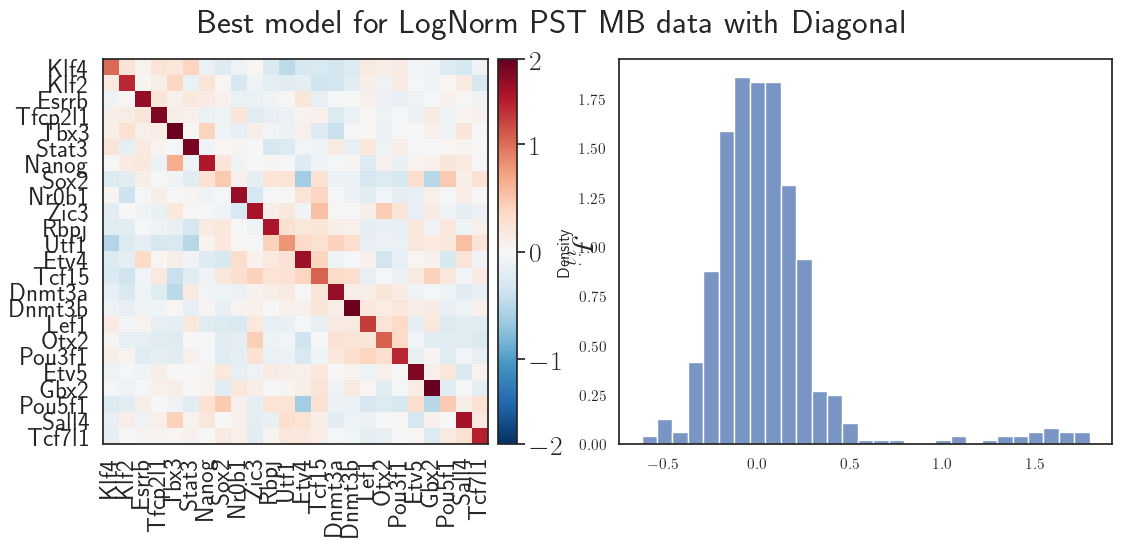

FCI correspondent to the lowest CMD: 0.67


/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/lib/figs_funcs.py:189: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbarM.ax.set_yticklabels(cbarM.ax.get_yticklabels(), fontname='Avenir')


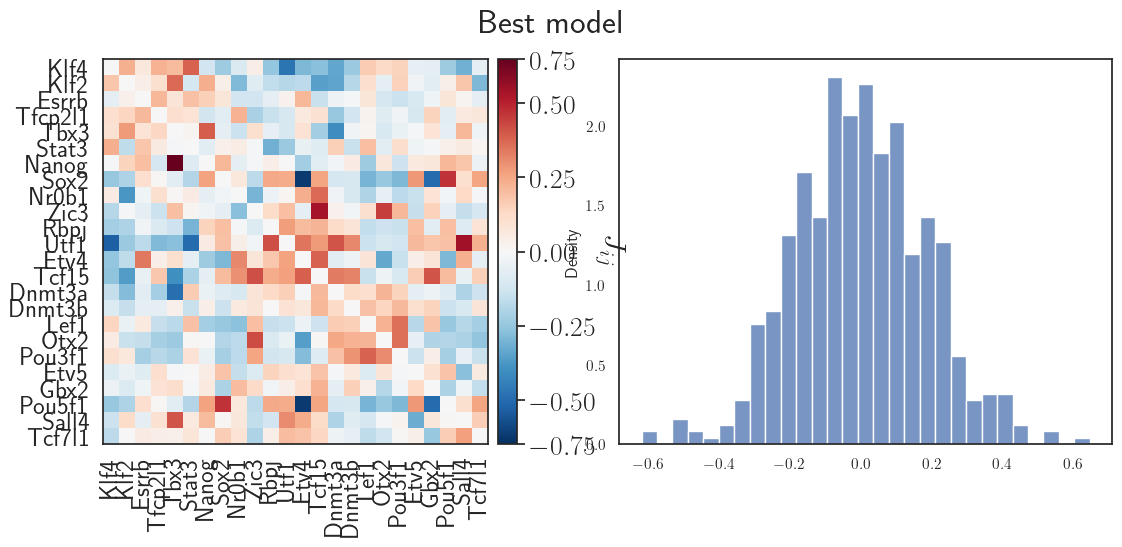

In [12]:
# Select the best inferred matrix.
# Use "use_prior=True" to select the best matrix that has the highest number of correctly inferred interactions (FCI)
# Use "use_prior=False" to select the best matrix that has the lowest distance between Correlation Matrices of the experimental and generated data (CMD)
lN_high_meanMatx, lN_model_idxs = funcs_general.select_best_inferred_matrix(
    lN_prec_sel_true, lN_dist_sel_true, lN_matx_sel_true, 
    stop=False, idx_sel=0, use_prior=False
    )
# Display information about the best model
print(f"Index of the model that satisfied the condition: {lN_model_idxs}")
print(f"Number of Used Matrices: {len(lN_model_idxs)}")

# Evaluate the best model
lN_Mean_TP_frac, lN_Mean_info_int, _ = funcs_general.TP_plot(
    literature_based_interactions, lN_high_meanMatx, genes_relevant, 
    inferred_int_thr=0, Norm_Matx=False,
    data_type=" Best model for LogNorm PST MB data with Diagonal",
    figplot=True, verbose=False, nbin=30, Norm=True
)
print(f"FCI correspondent to the lowest CMD: {lN_Mean_TP_frac:.2f}")

# Process the matrix by setting the diagonal to zero
lN_high_meanMatx_noDiag = np.copy(lN_high_meanMatx)
np.fill_diagonal(lN_high_meanMatx_noDiag, 0)
# Re-evaluate with the modified matrix
lN_Mean_TP_frac, lN_Mean_info_int, _ = funcs_general.TP_plot(
    literature_based_interactions, lN_high_meanMatx_noDiag, genes_relevant, 
    inferred_int_thr=0, Norm_Matx=False,
    data_type="Best model",
    figplot=True, verbose=False, nbin=30, Norm=True
)


# Implementation for reshuffled data

In [13]:
N_trials = 50  # on the parameters
# N_test as the number of shuffled datasets "spins_df_lN_mb_pst_shuffle"
compute = False

if compute:
    # initialize the arrays
    lN_matx_sel_rnd = np.zeros((N_test, N_trials, len(genes_relevant), len(genes_relevant)))
    lN_prec_sel_rnd = np.zeros((N_test, N_trials))
    lN_dist_sel_rnd = np.zeros((N_test, N_trials))
    lN_int_val_rnd  = np.zeros((4, len(literature_based_interactions), N_trials, N_test))
    # run the grid search
    for ii in range(N_test):
        print("\n Testing Sample "+str(ii+1))

        lN_matx_sel_rnd[ii,:,:,:],  lN_prec_sel_rnd[ii, :], lN_dist_sel_rnd[ii, :],  lN_int_val_rnd[:, :, :, ii]  = funcs_Ising.grid_search(np.array(spins_df_lN_mb_pst_shuffle[ii,:,:]), 
                                                                                                        params, literature_based_interactions, 
                                                                                                        genes_relevant, seedSet=ii*2, 
                                                                                                        Ntrials = N_trials,
                                                                                                        Norm=True, 
                                                                                                        cm_original_lN=cm_original_lN, noise_dist=noise_dist) # last inputs for the distance computation
else:
    # LOADING the data    
    lN_arrays_rnd = np.load(path_data+'OUT_ISING/LogNORM/lN_arrays_pst_mb_noprior_RND_24_01_12.npz') 
    lN_matx_sel_rnd = lN_arrays_rnd['array_1']
    lN_prec_sel_rnd = lN_arrays_rnd['array_2']
    lN_int_val_rnd = lN_arrays_rnd['array_3']
    lN_dist_sel_rnd = lN_arrays_rnd['array_4']
    

In [14]:
saving = False # Change to True to save the results. WARNING: This will overwrite the previous results if the date is not changed
if saving:
    save_path = path_data / 'OUT_ISING/LogNORM'
    save_path.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist

    file_name = 'lN_arrays_pst_mb_noprior_RND_24_01_12.npz'
    np.savez(save_path / file_name, array_1=lN_matx_sel_rnd, array_2=lN_prec_sel_rnd, array_3=lN_int_val_rnd, array_4=lN_dist_sel_rnd)

# Test

In [16]:
figs_path = "/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/FIG"

IN random:  Nanog Otx2 -1 0.0023450391510305172
IN random:  Stat3 Gbx2 1 -0.00790379944227001
IN random:  Tcf7l1 Nr0b1 -1 -0.007399379753058691


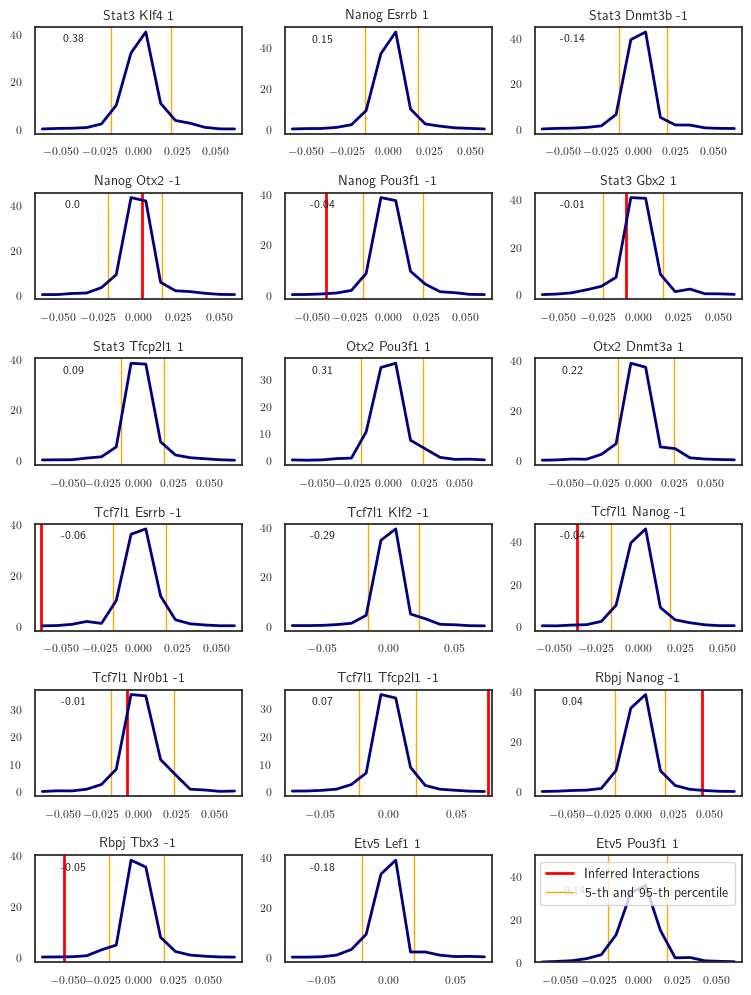

In [17]:
lN_matx_sel_rnd_all = lN_matx_sel_rnd.reshape((N_trials*N_test,len(genes_relevant),len(genes_relevant)))

funcs_sanity.single_int_check(literature_based_interactions, lN_matx_sel_rnd_all, lN_Mean_info_int, genes_relevant, text="")
plt.savefig(figs_path + "/IGNITE_lN_single_int_null_model_check.svg", bbox_inches='tight', transparent=True)
plt.show()
plt.close()